## Setup & data preparation

### install dependencies & import lib's

In [ ]:
pip install datasets evaluate

In [ ]:
pip install --upgrade transformers

In [ ]:
# classification(comments)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import Trainer, TrainingArguments, pipeline, AutoTokenizer, AutoModelForMaskedLM
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from datasets import Dataset

### load dataset

In [ ]:
# df=pd.read_csv('/content/drive/MyDrive/NLP/Dataset/darija_clean.csv')
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/NLP Dataset/sentences/darija_clean.csv')

In [ ]:
df1=df.copy()
df2=df.copy()

In [ ]:
df1

,cleaned_text,label,sentence_length
0,الي كيقولوا الشرع اعطاه اربعة وهو محامي عاد وم...,positive,967
1,الي كيقولوا الشرع اعطاه اربعة وهو محامي عاد وم...,neutral,967
2,واش هادا كايبغيك باله عليك لي كايهدر معاك بهاد...,negative,993
3,فظائح ومهازل والشعب التونسي يعاني البطالة والف...,Negative,983
4,يعطيه الصحة على الأقل لقينا واحد فاهم الحكاية ...,Positive,883
...,...,...,...
43693,Ya ta7an,Negative,8
43694,أنا أؤمن,neutral,8
43695,كيدايرة؟,Neutral,8
43696,اول لايك,neutral,8


### split dataset

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Assuming `df1` is your initial dataset
# Split into 80% training and 20% testing
train_df, test_df = train_test_split(df1, test_size=0.2, random_state=42)

# Further split the training set into 65% training and 15% validation
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

# Create Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 29714
Validation set size: 5244
Test set size: 8740


### tokenization & embedding

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer for DarijaBERT
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")

# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(examples["cleaned_text"], padding="max_length", truncation=True, max_length=512)

# Apply tokenization to all datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


vocab.txt:   0%|          | 0.00/879k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Map:   0%|          | 0/29714 [00:00<?, ? examples/s]

Map:   0%|          | 0/5244 [00:00<?, ? examples/s]

Map:   0%|          | 0/8740 [00:00<?, ? examples/s]

### transformation

In [ ]:
# Normalize labels
def normalize_label(label):
    label_mapping = {
        'negative': 'negative',
        'Negative': 'negative',
        'négatif': 'negative',
        'neutral': 'neutral',
        'Neutral': 'neutral',
        'positif': 'positive',
        'Positive': 'positive',
        'positive': 'positive',
        'mixed': 'mixed',
        'Mixed': 'mixed',
        'neutre': 'neutral'
    }
    return label_mapping.get(label.lower(), label)

# Map labels to numeric values
label_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'mixed': 3}

# Apply normalization and mapping
train_dataset = train_dataset.map(lambda x: {'label': normalize_label(x['label'])})
val_dataset = val_dataset.map(lambda x: {'label': normalize_label(x['label'])})
test_dataset = test_dataset.map(lambda x: {'label': normalize_label(x['label'])})

train_dataset = train_dataset.map(lambda x: {'labels': label_map[x['label']]})
val_dataset = val_dataset.map(lambda x: {'labels': label_map[x['label']]})
test_dataset = test_dataset.map(lambda x: {'labels': label_map[x['label']]})

Map:   0%|          | 0/29714 [00:00<?, ? examples/s]

Map:   0%|          | 0/5244 [00:00<?, ? examples/s]

Map:   0%|          | 0/8740 [00:00<?, ? examples/s]

Map:   0%|          | 0/29714 [00:00<?, ? examples/s]

Map:   0%|          | 0/5244 [00:00<?, ? examples/s]

Map:   0%|          | 0/8740 [00:00<?, ? examples/s]

In [ ]:
print(f"Unique labels in the train dataset: {set(train_dataset['labels'])}")
print(f"Unique labels in the validation dataset: {set(val_dataset['labels'])}")

Unique labels in the train dataset: {0, 1, 2, 3}
Unique labels in the validation dataset: {0, 1, 2, 3}


In [ ]:
# Set format for PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

## Train & evaluate model (fine tuning)

### PEFT

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import numpy as np

# Load the model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("SI2M-Lab/DarijaBERT", num_labels=4)

# Configure LoRA for Sequence Classification
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence Classification
    inference_mode=False,
    r=8,  # Low-rank dimension
    lora_alpha=32,
    lora_dropout=0.1,
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Define metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)

    # Load metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    # precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    # recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"]
        # "precision": precision["precision"],
        # "recall": recall["recall"],
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_model_2",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=["none"],  # Avoid using wandb or other integrations
    save_total_limit=1,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


model.safetensors:   0%|          | 0.00/836M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-15-17e44a782ea8>:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.870800,0.791344,0.670481
2,0.717400,0.769564,0.683448
3,0.701000,0.756113,0.687643
4,0.713200,0.753028,0.691076
5,0.694900,0.751101,0.692029


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


TrainOutput(global_step=18575, training_loss=0.7811434758880739, metrics={'train_runtime': 11148.1902, 'train_samples_per_second': 13.327, 'train_steps_per_second': 1.666, 'total_flos': 3.922711526989824e+16, 'train_loss': 0.7811434758880739, 'epoch': 5.0})

### Save model

In [ ]:
# Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_darijaBERT_2")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


### evaluation

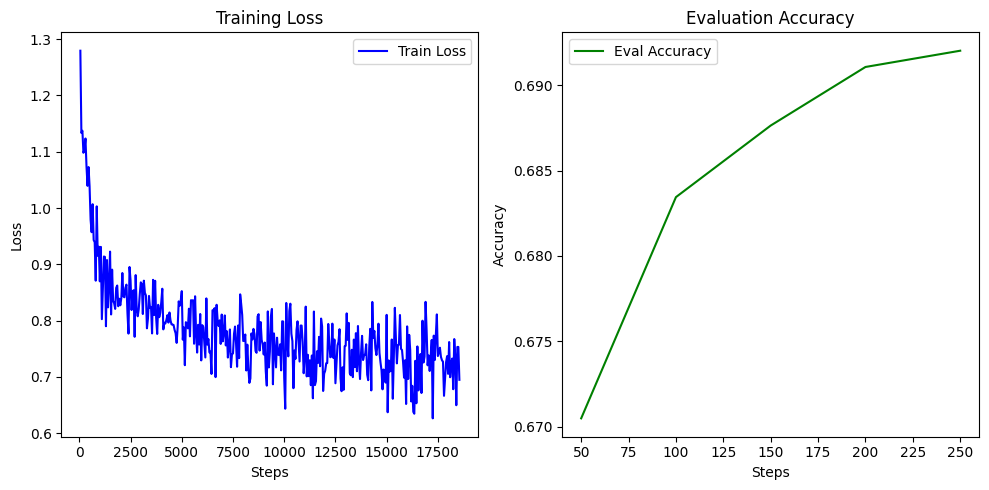

In [ ]:
import json
import matplotlib.pyplot as plt

# Path to the training log file
log_file_path = "/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_model_2/checkpoint-18575/trainer_state.json"

# Read and parse the log file
with open(log_file_path, 'r') as log_file:
    logs = json.load(log_file)

# Extract relevant data
steps = []
train_loss = []
eval_accuracy = []
eval_f1 = []

# Process log history
for log_entry in logs.get("log_history", []):
    if "step" in log_entry and "loss" in log_entry:
        steps.append(log_entry["step"])
        train_loss.append(log_entry["loss"])
    if "eval_accuracy" in log_entry:
        eval_accuracy.append(log_entry["eval_accuracy"])
    if "eval_f1" in log_entry:
        eval_f1.append(log_entry["eval_f1"])

# Plot the metrics
plt.figure(figsize=(15, 5))

# Loss curve
if train_loss:
    plt.subplot(1, 3, 1)
    plt.plot(steps[:len(train_loss)], train_loss, label="Train Loss", color="blue")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

# Accuracy curve
if eval_accuracy:
    plt.subplot(1, 3, 2)
    plt.plot(steps[:len(eval_accuracy)], eval_accuracy, label="Eval Accuracy", color="green")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy")
    plt.legend()

# F1-score curve
if eval_f1:
    plt.subplot(1, 3, 3)
    plt.plot(steps[:len(eval_f1)], eval_f1, label="Eval F1", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("F1-Score")
    plt.title("Evaluation F1-Score")
    plt.legend()

plt.tight_layout()
plt.show()

Epochs: 371 Train Losses: 371
Eval Epochs: 5 Eval Losses: 5
Train Accuracies: 0
Eval Accuracies: 5


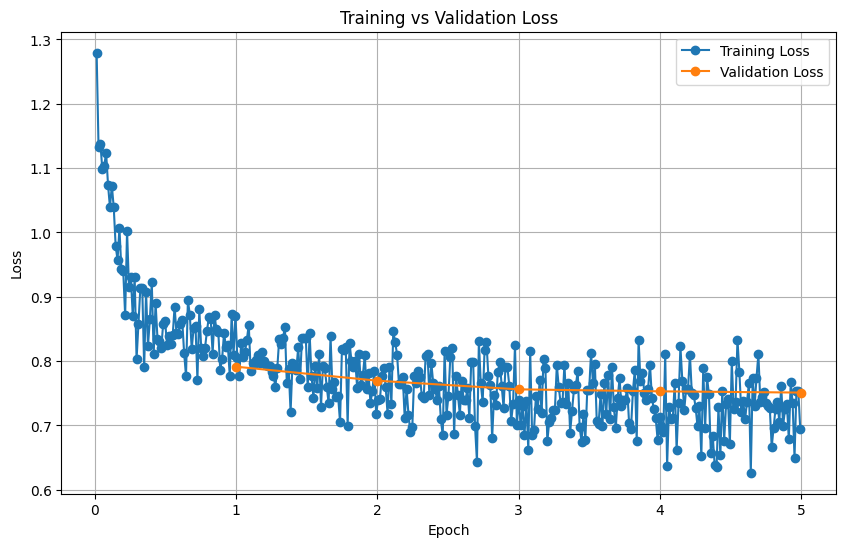

Not enough data to plot Training vs Validation Accuracy.


In [ ]:
import json
import matplotlib.pyplot as plt

# Path to the training log file
log_file_path = "/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_model_2/checkpoint-18575/trainer_state.json"

# Read and parse the log file
with open(log_file_path, 'r') as log_file:
    logs = json.load(log_file)

# Extract log history
log_history = logs.get("log_history", [])

# Collect data from logs
epochs = [log["epoch"] for log in log_history if "loss" in log]
train_losses = [log["loss"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
eval_epochs = [log["epoch"] for log in log_history if "eval_loss" in log]
train_accuracies = [log["accuracy"] for log in log_history if "accuracy" in log]
eval_accuracies = [log["eval_accuracy"] for log in log_history if "eval_accuracy" in log]
eval_epochs_accuracy = [log["epoch"] for log in log_history if "eval_accuracy" in log]

# Verify data sizes for alignment
print("Epochs:", len(epochs), "Train Losses:", len(train_losses))
print("Eval Epochs:", len(eval_epochs), "Eval Losses:", len(eval_losses))
print("Train Accuracies:", len(train_accuracies))
print("Eval Accuracies:", len(eval_accuracies))

# Plot Training vs Validation Loss
if epochs and train_losses and eval_epochs and eval_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss", marker="o")
    plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Not enough data to plot Training vs Validation Loss.")

# Plot Training vs Validation Accuracy
if epochs and train_accuracies and eval_epochs_accuracy and eval_accuracies:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
    plt.plot(eval_epochs_accuracy, eval_accuracies, label="Validation Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Not enough data to plot Training vs Validation Accuracy.")

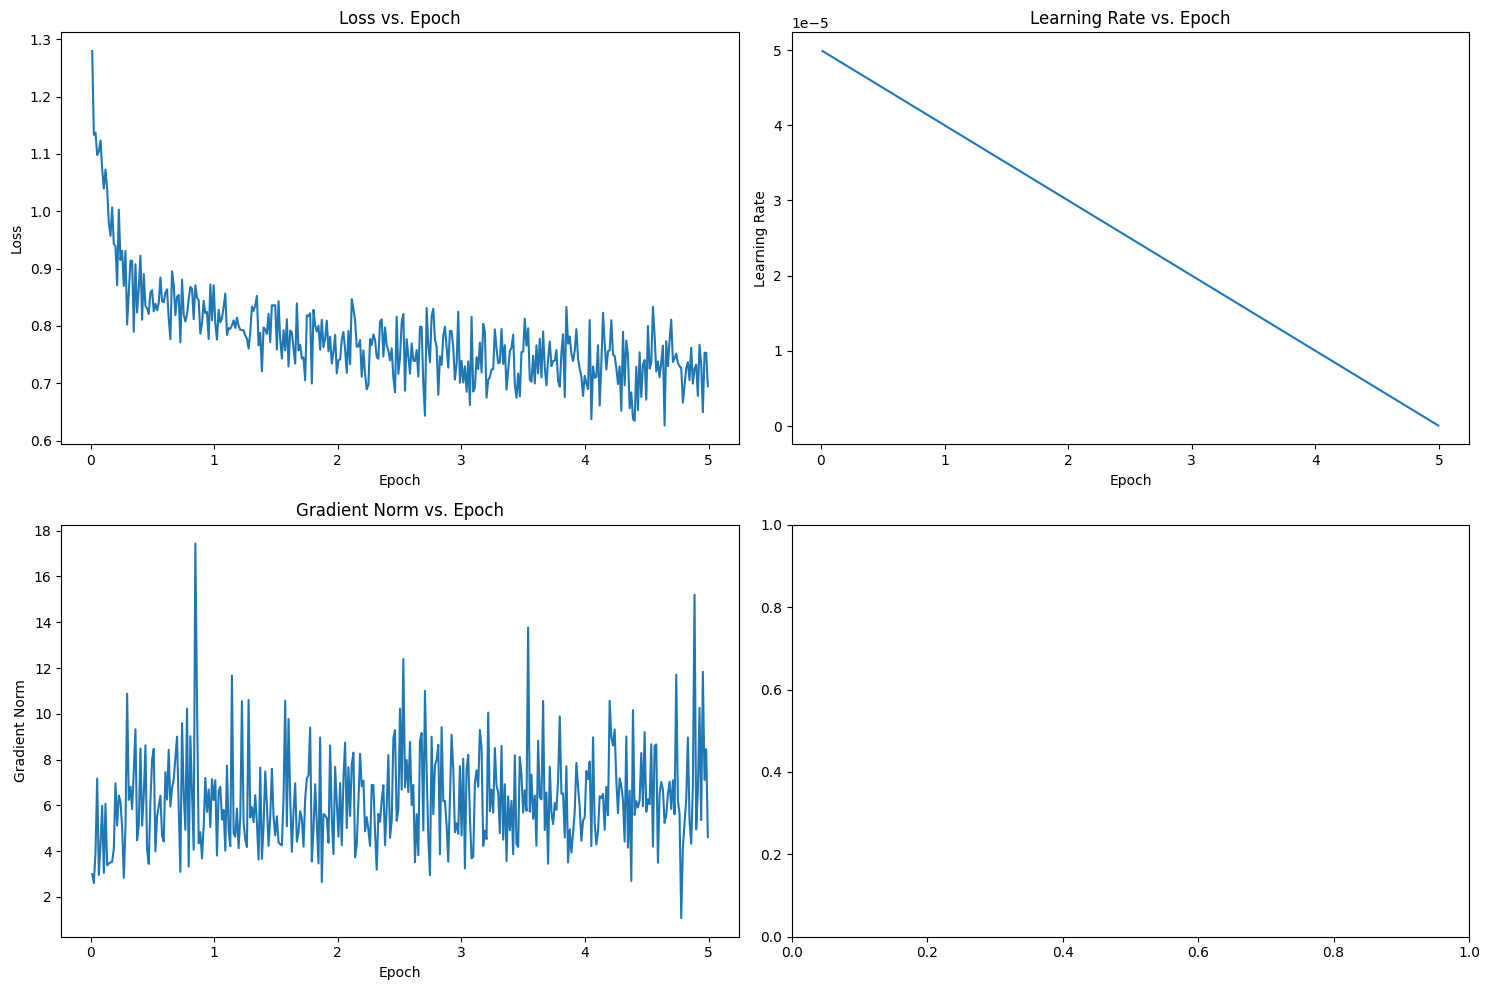

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import json

# Path to the training log file
log_file_path = "/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_model_2/checkpoint-18575/trainer_state.json"

# Read and parse the log file
with open(log_file_path, 'r') as log_file:
    logs = json.load(log_file)

# Extract relevant data from the log history
data = []
for entry in logs['log_history']:
    try:
        data.append({
            'epoch': entry['epoch'],
            'loss': entry['loss'],
            'learning_rate': entry['learning_rate'],
            'grad_norm': entry['grad_norm']
        })
    except KeyError:
        print(f"Warning: 'loss' key not found in entry. Skipping this entry.")
        # Optionally, add a placeholder value for loss
        # data.append({
        #     'epoch': entry['epoch'],
        #     'loss': None,  # or a default value like np.nan
        #     'learning_rate': entry['learning_rate'],
        #     'grad_norm': entry['grad_norm']
        # })

# Create a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loss vs. Epoch
axs[0, 0].plot(df['epoch'], df['loss'])
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Loss vs. Epoch')

# Learning Rate vs. Epoch
axs[0, 1].plot(df['epoch'], df['learning_rate'])
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Learning Rate')
axs[0, 1].set_title('Learning Rate vs. Epoch')

# Gradient Norm vs. Epoch
axs[1, 0].plot(df['epoch'], df['grad_norm'])
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Gradient Norm')
axs[1, 0].set_title('Gradient Norm vs. Epoch')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

Test Results: {'eval_loss': 0.7483528256416321, 'eval_accuracy': 0.6918764302059497, 'eval_runtime': 258.445, 'eval_samples_per_second': 33.818, 'eval_steps_per_second': 4.229, 'epoch': 5.0}


### test results

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Path to the saved model
model_path = "/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_darijaBERT_2"

# Load the fine-tuned model with the correct number of labels
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4)

# Load the tokenizer for the original pre-trained model
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")  # Use the same tokenizer as the pre-trained model

# Ensure the model is in evaluation mode
model.eval()

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(80000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_featur

In [ ]:
import numpy as np

def predict(text, model, tokenizer, max_length=128):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

    # Ensure the model is in inference mode
    model.eval()

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted labels (output logits)
    logits = outputs.logits
    predicted_class_id = np.argmax(logits.numpy(), axis=-1)  # Get the class with the highest logit

    # Convert predicted class id to label (e.g., 0 -> 'negative', 1 -> 'neutral', 2 -> 'positive', 3 -> 'mixed')
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive', 3: 'mixed'}
    predicted_label = label_map[predicted_class_id[0]]

    return predicted_label

In [ ]:
# Example text
text = "واش هادا كايبغيك باله عليك لي كايهدر معاك بهاد"

# Get the prediction
predicted_label = predict(text, model, tokenizer)

print(f"Predicted Label: {predicted_label}")

Predicted Label: positive


In [ ]:
 print(f"Predicted Label: {predict('علامة الرضى', model, tokenizer)}")

Predicted Label: mixed


## Interface

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gradio

In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_darijaBERT_2"

adapter_config.json  adapter_model.safetensors	README.md


In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_model_2/checkpoint-18575"

adapter_config.json	   README.md	  special_tokens_map.json  trainer_state.json
adapter_model.safetensors  rng_state.pth  tokenizer_config.json    training_args.bin
optimizer.pt		   scheduler.pt   tokenizer.json	   vocab.txt


Positive
- jomo3a mobarika
- had l film zwin
- ramadan karim

Negative
- ma7mltch had l film
- d3na fhad l blan

In [6]:
import gradio as gr
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F

# Path to the fine-tuned model directory
model_path = "/content/drive/MyDrive/Colab Notebooks/NLP/NLP_Project/Model/lora_finetuned_darijaBERT_2"

# Load the fine-tuned model with the correct number of labels
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4)

# Load the tokenizer for the original pre-trained model (DarijaBERT)
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")  # Use the tokenizer from the original pre-trained model

# Ensure the model is in evaluation mode
model.eval()

# Define the label mapping
label_map = {0: "negative", 1: "neutral", 2: "positive", 3: "mixed"}

# Define the prediction function
def classify_text(input_text):
    # Tokenize the input text using the original tokenizer
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512, padding=True)

    with torch.no_grad():
        # Forward pass to get predictions
        logits = model(**inputs).logits

    # Convert logits to probabilities
    probabilities = F.softmax(logits, dim=-1).squeeze().tolist()

    # Get predicted label
    label_id = torch.argmax(logits, dim=-1).item()
    predicted_label = label_map[label_id]

    # Prepare the class probabilities as a dataframe format (for better display)
    probability_data = [(label_map[i], round(probabilities[i], 4)) for i in range(len(probabilities))]

    return predicted_label, probability_data

# Create the Gradio interface
interface = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(lines=5, label="Input Text"),
    outputs=[
        gr.Label(label="Predicted Label"),  # Stylish label for prediction
        gr.Dataframe(label="Class Probabilities", headers=["Category", "Probability"], datatype=["str", "str"]),  # Probabilities as a dataframe
    ],
    title="DarijaBERT Text Classifier",
    description="Enter text in Darija to classify it into one of the following categories: negative, neutral, positive, or mixed.",
    theme="compact",  # Compact theme for a cleaner look
)

# Launch the Gradio app
interface.launch()

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


vocab.txt:   0%|          | 0.00/879k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:1049: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-677e7152-4cc74b32282917b240a629ca;f05665b7-ff49-4dbb-8d0e-ead4cc55e850)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d71df0536854318336.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
